In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
import numpy as np
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [2]:
%matplotlib inline
import os
import operator
import numpy as np
import pandas as pd
from football_loader import metrics


def load_league_csv(league, start_year=2005):
    df = None
    files = os.listdir(f'fulldata/{league}')
    files.sort()
    for file in files:
        year = int(file.strip('.csv'))
        if year < start_year:
            continue
        df_year = pd.read_csv(f'fulldata/{league}/' + file,
                              engine='python',
                              # skiprows=1,
                              # index_col=None,
                              # names=['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A']
                              )
        df_year.reset_index(drop=True, inplace=True)
        df_year['Year'] = year
        df_year['Match'] = df_year.index + 1

        if df is None:
            df = df_year
        else:
            df = df.append(df_year, ignore_index=True, sort=False)

    # print(len(df))
    # print(df.shape)

    # remove unused columns
    # df_league = None
    df.reset_index(inplace=True)
    # df = df[['Year', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    #          "B365H", "B365D", "B365A"]]
    return df


def make_features(df, teams):
    # df_league = None
    ret = {}

    # if teams is None:
    #     teams = np.unique(df.loc[df['Year'] == predict_year, 'HomeTeam'].values)
    #     teams.sort()
    for team in teams:

        df_team = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]
        all = pd.DataFrame(
            data={
                'Year': df_team['Year'],
                'Date': df_team['Date'],
                'Team': team,
                'HomeMatch': df_team['HomeTeam'] == team
            }
        )
        all['Opponent'] = np.where(all['HomeMatch'], df_team['AwayTeam'], df_team['HomeTeam'])
        # X['HalfTimeGoals'] = np.where(X['HomeMatch'], df_team['HTHG'], df_team['HTAG'])
        # X['HalfTimeOpponentGoals'] = np.where(X['HomeMatch'], df_team['HTAG'], df_team['HTHG'])
        # X['HalfTimeLead'] = X['HalfTimeGoals'] > X['HalfTimeOpponentGoals']
        # X['HalfTimeLeadMoreThanTwo'] = (X['HalfTimeGoals'] - X['HalfTimeOpponentGoals']) > 2
        # X['FullTimeGoals'] = np.where(X['HomeMatch'], ath_madrid['FTHG'], ath_madrid['FTAG'])
        # X['FullTimeOpponentGoals'] = np.where(X['HomeMatch'], ath_madrid['FTAG'], ath_madrid['FTHG'])
        all['FTR'] = df_team['FTR']
        # all['Won'] = np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A')
        all['Won'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'H', df_team['FTR'] == 'A'))
        all['Draw'] = np.where(df_team['FTR'] == '', False, df_team['FTR'] == 'D')
        all['Lost'] = np.where(df_team['FTR'] == '', False, np.where(all['HomeMatch'], df_team['FTR'] == 'A', df_team['FTR'] == 'H'))
        all['Result'] = np.where(df_team['FTR'] == '', '', np.where(all['Won'], 'Win', (np.where(all['Lost'], 'Lose', 'Draw'))))
        # X['SumGoals'] = X.groupby('Opponent')['FullTimeGoals'].transform(sum)
        all['B365Max'] = np.maximum(np.maximum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Min'] = np.minimum(np.minimum(df_team['B365H'], df_team['B365A']), df_team['B365D'])
        all['B365Say'] = np.where(all['HomeMatch'],
                                  # home match
                                  np.where(all['B365Max'] == df_team['B365H'], -1,
                                           np.where(all['B365Max'] == df_team['B365A'], 1,
                                                    0)),
                                  # away match
                                  np.where(all['B365Max'] == df_team['B365H'], 1,
                                           np.where(all['B365Max'] == df_team['B365A'], -1,
                                                    0))
                                  )
        # all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Max'] - all['B365Min'],
        #                            all['B365Min'] - all['B365Max'])
        all['B365Diff'] = np.where(all['B365Say'] == 1, all['B365Min'] - all['B365Max'],
                                   np.where(all['B365Say'] == -1, all['B365Max'] - all['B365Min'],
                                            # draw
                                            np.where(all['HomeMatch'],
                                            df_team['B365A'] - df_team['B365H'],
                                            df_team['B365H'] - df_team['B365A']
                                            ))) * -1
        all['Corners'] = np.where(all['HomeMatch'], df_team['HC'], df_team['AC'])
        all['Shots'] = np.where(all['HomeMatch'], df_team['HS'], df_team['AS'])
        all['ShotsOnTarget'] = np.where(all['HomeMatch'], df_team['HST'], df_team['AST'])
        all['Points'] = np.where(all['Won'], 3,
                                 np.where(all['Draw'], 1, 0)
                                  )
        all['AdjustedPoints'] = np.where(all['HomeMatch'],
                                  # home match
                                         np.where(all['Won'], 1,
                                                  np.where(all['Draw'], 0, -1)
                                                  )
                                         ,
                                  # away match
                                         np.where(all['Won'], 1.5,
                                                  np.where(all['Draw'], 0.5, 0)
                                                  )
                                  )
        all['Goals'] = np.where(all['HomeMatch'], df_team['FTHG'], df_team['FTAG'])
        all['Conceded'] = np.where(all['HomeMatch'], df_team['FTAG'], df_team['FTHG'])

        # find number of times won against this opponent in last 5 meetings
        for key, groupByOpponent in all.groupby('Opponent'):
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByOpponent.index

            # make match day an index because rolling need an index date
            xx = groupByOpponent.set_index('Date')
            xx['idx'] = idx
            # shift to exclude self
            xx['Last5AgainstThisOpponentWon'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last5AgainstThisOpponentDraw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['Last5AgainstThisOpponentLost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['Last3AgainstThisOpponentWon'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['Last3AgainstThisOpponentDraw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)

            xx['LastAgainstThisOpponentWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            xx['LastAgainstThisOpponentDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
            # xx['LastThisOpponentLost'] = xx['Lost'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            all.loc[xx.index, 'Last5AgainstThisOpponentWon'] = xx['Last5AgainstThisOpponentWon']
            all.loc[xx.index, 'Last5AgainstThisOpponentDraw'] = xx['Last5AgainstThisOpponentDraw']
            # X.loc[xx.index, 'Last5AgainstThisOpponentLost'] = xx['Last5AgainstThisOpponentLost']
            all.loc[xx.index, 'Last3AgainstThisOpponentWon'] = xx['Last3AgainstThisOpponentWon']
            all.loc[xx.index, 'Last3AgainstThisOpponentDraw'] = xx['Last3AgainstThisOpponentDraw']
            all.loc[xx.index, 'LastAgainstThisOpponentWon'] = xx['LastAgainstThisOpponentWon']
            all.loc[xx.index, 'LastAgainstThisOpponentDraw'] = xx['LastAgainstThisOpponentDraw']
            # X.loc[xx.index, 'LastThisOpponentLost'] = xx['LastThisOpponentLost']

        # stats by year/season
        for year, groupByYear in all.groupby('Year'):
            # print(year)
            # keep index as new a column, will be restored and assigned back to X later
            idx = groupByYear.index

            # make match day an index because rolling need an index date
            xx = groupByYear.set_index('Date')
            xx['idx'] = idx

            # shift to exclude self
            xx['CornersSoFar'] = np.nancumsum(xx['Corners'].shift())
            xx['ShotsSoFar'] = np.nancumsum(xx['Shots'].shift())
            xx['ShotsOnTargetSoFar'] = np.nancumsum(xx['ShotsOnTarget'].shift())
            xx['GoalsSoFar'] = np.nancumsum(xx['Goals'].shift())
            xx['ConcededSoFar'] = np.nancumsum(xx['Conceded'].shift())

            xx['HomeWonNum'] = np.where(xx['HomeMatch'] & xx['Won'], 1, 0)
            xx['HomeWonSoFar'] = np.nancumsum(xx['HomeWonNum'].shift())
            xx['AwayWonNum'] = np.where((xx['HomeMatch'] == False) & xx['Won'], 1, 0)
            xx['AwayWonSoFar'] = np.nancumsum(xx['AwayWonNum'].shift())

            xx['PointsSoFar'] = np.nancumsum(xx['Points'].shift())
            xx['AdjustedPointsSoFar'] = np.nancumsum(xx['AdjustedPoints'].shift())

            # restore index
            xx = xx.set_index('idx')

            # assign back to the big dataframe
            # all.loc[xx.index, 'CornersSoFar'] = xx['CornersSoFar']
            # all.loc[xx.index, 'ShotsSoFar'] = xx['ShotsSoFar']
            # all.loc[xx.index, 'ShotsOnTargetSoFar'] = xx['ShotsOnTargetSoFar']
            # all.loc[xx.index, 'GoalsSoFar'] = xx['GoalsSoFar']
            # all.loc[xx.index, 'ConcededSoSoFar'] = xx['ConcededSoSoFar']
#             all.loc[xx.index, 'HomeWonSoFar'] = xx['HomeWonSoFar']
#             all.loc[xx.index, 'AwayWonSoFar'] = xx['AwayWonSoFar']
            all.loc[xx.index, 'PointsSoFar'] = xx['PointsSoFar']
            all.loc[xx.index, 'AdjustedPointsSoFar'] = xx['AdjustedPointsSoFar']

        # find recent forms
        idx = all.index
        xx = all.set_index('Date')
        xx['idx'] = idx
        xx['Last5Won'] = xx['Won'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last5Draw'] = xx['Draw'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        # xx['Last5Lost'] = xx['Lost'].rolling(6).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Won'] = xx['Won'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['Last3Draw'] = xx['Draw'].rolling(4).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastWon'] = xx['Won'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)
        xx['LastDraw'] = xx['Draw'].rolling(2).apply(lambda x: np.nansum(x.shift()), raw=False)

        # restore index
        xx = xx.set_index('idx')
        # assign back to the big dataframe
        all.loc[xx.index, 'Last5Won'] = xx['Last5Won']
        all.loc[xx.index, 'Last5Draw'] = xx['Last5Draw']
        all.loc[xx.index, 'Last3Won'] = xx['Last3Won']
        all.loc[xx.index, 'Last3Draw'] = xx['Last3Draw']
        all.loc[xx.index, 'LastWon'] = xx['LastWon']
        all.loc[xx.index, 'LastDraw'] = xx['LastDraw']
        # X.loc[xx.index, 'Last5Lost'] = xx['Last5Lost']

        # replace nan with 0
        # TODO: better way to handle nan
        # all.loc[np.isnan(all['FTR']), 'FTR'] = ''
        all.loc[np.isnan(all['Last5AgainstThisOpponentWon']), 'Last5AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last5AgainstThisOpponentDraw']), 'Last5AgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['Last5AgainstThisOpponentLost']), 'Last5AgainstThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentWon']), 'Last3AgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['Last3AgainstThisOpponentDraw']), 'Last3AgainstThisOpponentDraw'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentWon']), 'LastAgainstThisOpponentWon'] = 0
        all.loc[np.isnan(all['LastAgainstThisOpponentDraw']), 'LastAgainstThisOpponentDraw'] = 0
        # X.loc[np.isnan(X['LastThisOpponentLost']), 'LastThisOpponentLost'] = 0
        all.loc[np.isnan(all['Last5Won']), 'Last5Won'] = 0
        all.loc[np.isnan(all['Last5Draw']), 'Last5Draw'] = 0
        # X.loc[np.isnan(X['Last5Lost']), 'Last5Lost'] = 0
        all.loc[np.isnan(all['Last3Won']), 'Last3Won'] = 0
        all.loc[np.isnan(all['Last3Draw']), 'Last3Draw'] = 0
        all.loc[np.isnan(all['LastWon']), 'LastWon'] = 0
        all.loc[np.isnan(all['LastDraw']), 'LastDraw'] = 0
        all.loc[np.isnan(all['B365Diff']), 'B365Diff'] = 0

        # restrict training data (too old data may not be irrelevance)
        X = all
        Y = X[['Result']]
        # del X['Result']
        # X = all.loc[(all['Year'] >= train_year) & (all['Year'] < predict_year)]
        # Y = all[['Result']]

        # split data into train - test sets
        # x_train = X[(X['Year'] < predict_year)]
        # y_train = Y[(X['Year'] < predict_year)]
        # x_test = X[(X['Year'] >= predict_year)]
        # y_test = Y[(X['Year'] >= predict_year)]
        # X['Predict'] = ''
        close_leaks(X)
        ret[team] = [X, Y]
    return ret


# call this after you've split data
def close_leaks(X):
    # remove duplicate features
#     del X['LastWon']
#     del X['LastDraw']

    # prevent future leaks
    # result = pd.DataFrame(X['Result'])
    del X['Result']
    del X['Lost']
    del X['Draw']
    del X['Won']
    del X['FTR']
    del X['Date']
    del X['Opponent']
    del X['Team']
    del X['B365Max']
    del X['B365Min']
    del X['Corners']
    del X['Shots']
    del X['ShotsOnTarget']
    del X['Points']
    del X['AdjustedPoints']
    del X['Goals']
    del X['Conceded']


In [3]:
league = 'english'
validate_year = 2016
test_year = 2017
train_year = 2005
df = load_league_csv(league)

In [4]:
teams = df.loc[(df['Year'] == validate_year) | (df['Year'] == test_year), 'HomeTeam']
teams = teams.unique()
teams.sort()
print(teams)
print(len(teams))

['Arsenal' 'Bournemouth' 'Brighton' 'Burnley' 'Chelsea' 'Crystal Palace'
 'Everton' 'Huddersfield' 'Hull' 'Leicester' 'Liverpool' 'Man City'
 'Man United' 'Middlesbrough' 'Newcastle' 'Southampton' 'Stoke'
 'Sunderland' 'Swansea' 'Tottenham' 'Watford' 'West Brom' 'West Ham']
23


In [5]:
teams = make_features(df, teams)
classes = ['Draw', 'Lose', 'Win']

In [6]:
print('X')
print(teams[next(iter(teams))][0].count()) # X
print('Y')
print(teams[next(iter(teams))][1].count()) # Y
print(len(teams), 'teams')

X
Year                            502
HomeMatch                       502
B365Say                         502
B365Diff                        502
Last5AgainstThisOpponentWon     502
Last5AgainstThisOpponentDraw    502
Last3AgainstThisOpponentWon     502
Last3AgainstThisOpponentDraw    502
LastAgainstThisOpponentWon      502
LastAgainstThisOpponentDraw     502
PointsSoFar                     502
AdjustedPointsSoFar             502
Last5Won                        502
Last5Draw                       502
Last3Won                        502
Last3Draw                       502
LastWon                         502
LastDraw                        502
dtype: int64
Y
Result    502
dtype: int64
23 teams


In [7]:
total = None
for team in teams:
# for team in ['Arsenal']:
    X = teams[team][0]
    Y = teams[team][1]
    # split data into train - validate - test sets
    x_train = X[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    y_train = Y[(X['Year'] >= train_year) & (X['Year'] < validate_year)]
    x_validate = X[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    y_validate = Y[(X['Year'] >= validate_year) & (X['Year'] < test_year)]
    x_test = X[(X['Year'] >= test_year)]
    y_test = Y[(X['Year'] >= test_year)]
    if len(x_train) <= 0 or len(x_test) <= 0 or len(x_validate) <= 0:
        print(f'skip {team}')
        continue
    
    validate_accuracies = {}
    test_accuracies = {}
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train['Result'])
    y_validate_pred = lr.predict(x_validate)
    validate_accuracies['LogisticRegression'] = accuracy_score(y_validate, y_validate_pred) * 100
    y_test_pred = lr.predict(x_test)
    test_accuracies['LogisticRegression'] = accuracy_score(y_test, y_test_pred) * 100
    y_validate_prob = lr.predict_proba(x_validate)
    y_test_prob = lr.predict_proba(x_test)
#     print(y_validate_prob)
#     print(y_test_prob)
    prob = np.vstack((y_validate_prob, y_test_prob))
#     print(prob)
#     print(prob[:,0])
#     print(np.max(prob, axis=1))
#     print(np.min(prob, axis=1))
    d = pd.DataFrame(
        data={
            'Year': x_validate['Year'].append(x_test['Year']),
            'Team': team,
            'Predict': np.append(y_validate_pred, y_test_pred),
            'Actual': y_validate['Result'].append(y_test['Result']),
            'DrawProb': prob[:,0],
            'LoseProb': prob[:,1],
            'WinProb': prob[:,2],
            'MaxProb': np.max(prob, axis=1),
            'MinProb': np.min(prob, axis=1)
        },
        index=np.append(y_validate.index, y_test.index)
#         index=pd.MultiIndex.from_tuples(
#             list(zip(np.repeat('LogisticRegression', len(y_test.index)), y_test.index.values)),
#             names=['predictor', 'match_id'])
    )
    if total is None:
        total = d
    else:
        total = total.append(d)
    for (k, v) in validate_accuracies.items():
        print(f"{k}: {team} validation accuracy are: {v}")
#         cm = confusion_matrix(y_validate, y_validate_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
        print(f"{k}: {team} test accuracy are: {test_accuracies[k]}")
#         cm = confusion_matrix(y_test, y_test_pred, labels=classes)
#         metrics.plot_confusion_matrix(cm, classes, title=team)
#     print(lr.coef_)
    



LogisticRegression: Arsenal validation accuracy are: 63.1578947368421
LogisticRegression: Arsenal test accuracy are: 69.56521739130434
LogisticRegression: Bournemouth validation accuracy are: 55.26315789473685
LogisticRegression: Bournemouth test accuracy are: 45.65217391304348
skip Brighton
LogisticRegression: Burnley validation accuracy are: 52.63157894736842
LogisticRegression: Burnley test accuracy are: 32.608695652173914
LogisticRegression: Chelsea validation accuracy are: 76.31578947368422
LogisticRegression: Chelsea test accuracy are: 56.52173913043478
LogisticRegression: Crystal Palace validation accuracy are: 44.73684210526316
LogisticRegression: Crystal Palace test accuracy are: 56.52173913043478
LogisticRegression: Everton validation accuracy are: 42.10526315789473
LogisticRegression: Everton test accuracy are: 63.04347826086957
skip Huddersfield
skip Hull
LogisticRegression: Leicester validation accuracy are: 44.73684210526316
LogisticRegression: Leicester test accuracy are

In [9]:
# for key, groupByPredictor in total.groupby('predictor'):
#     print(f"{key} overall accuracy is ", accuracy_score(groupByPredictor['actual'], groupByPredictor['pred'])*100)
print(f"Overall accuracy is ", accuracy_score(total['Actual'], total['Predict'])*100)

Overall accuracy is  53.205128205128204


In [10]:
total

,Year,Team,Predict,Actual,DrawProb,LoseProb,WinProb,MaxProb,MinProb
4188,2016,Arsenal,Win,Lose,0.316563,0.328489,0.354948,0.354948,0.316563
4193,2016,Arsenal,Win,Draw,0.110750,0.275762,0.613488,0.613488,0.110750
4208,2016,Arsenal,Win,Win,0.113264,0.112295,0.774442,0.774442,0.112295
4211,2016,Arsenal,Win,Win,0.210041,0.168099,0.621859,0.621859,0.168099
4223,2016,Arsenal,Win,Win,0.243384,0.129176,0.627440,0.627440,0.129176
4231,2016,Arsenal,Draw,Win,0.370888,0.310069,0.319043,0.370888,0.310069
4247,2016,Arsenal,Win,Win,0.071672,0.108559,0.819770,0.819770,0.071672
4251,2016,Arsenal,Win,Win,0.177461,0.110696,0.711844,0.711844,0.110696
4261,2016,Arsenal,Win,Draw,0.055047,0.027553,0.917401,0.917401,0.027553
4274,2016,Arsenal,Win,Win,0.185683,0.178489,0.635828,0.635828,0.178489


In [11]:
chart_data = {}
chart_data_all = None
for team, dataset in teams.items():
    chart_data_team = pd.DataFrame(dataset[0])
    chart_data_team = chart_data_team[(chart_data_team['Year'] >= validate_year) | (chart_data_team['Year'] >= test_year)]
    chart_data_team['Actual'] = dataset[1]['Result']
    i = total[total.index.isin(chart_data_team.index)]
    chart_data_team.loc[i.index, 'Predict'] = i['Predict']
    chart_data_team['Point'] = np.where(chart_data_team['Actual'] == 'Win', 3,
                                 np.where(chart_data_team['Actual'] == 'Draw', 1, 0)
                                  )
    chart_data_team['PointPredict'] = np.where(chart_data_team['Predict'] == 'Win', 3,
                                 np.where(chart_data_team['Predict'] == 'Draw', 1, 0)
                                  )
    for key, groupByYear in chart_data_team.groupby('Year'):
        chart_data_team.loc[groupByYear.index, 'MatchNo'] = range(1,len(groupByYear['Actual'])+1)
        chart_data_team.loc[groupByYear.index, 'TotalPoints'] = np.nancumsum(groupByYear['Point'])
        chart_data_team.loc[groupByYear.index, 'TotalPointsPredict'] = np.nancumsum(groupByYear['PointPredict'])
        
    chart_data_team['Team'] = team
    chart_data[team] = chart_data_team
    if chart_data_all is None:
        chart_data_all = chart_data_team
    else:
        chart_data_all = chart_data_all.append(chart_data_team, ignore_index=True, sort=False)
chart_data_all

,Year,HomeMatch,B365Say,B365Diff,Last5AgainstThisOpponentWon,Last5AgainstThisOpponentDraw,Last3AgainstThisOpponentWon,Last3AgainstThisOpponentDraw,LastAgainstThisOpponentWon,LastAgainstThisOpponentDraw,...,LastWon,LastDraw,Actual,Predict,Point,PointPredict,MatchNo,TotalPoints,TotalPointsPredict,Team
0,2016,True,0,-0.70,1.0,3.0,1.0,2.0,0.0,1.0,...,1.0,0.0,Lose,Draw,0,1,1.0,0.0,1.0,Arsenal
1,2016,False,0,-0.38,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,Draw,Lose,1,0,2.0,1.0,1.0,Arsenal
2,2016,False,1,3.27,0.0,0.0,3.0,0.0,1.0,0.0,...,0.0,1.0,Win,Lose,3,0,3.0,4.0,1.0,Arsenal
3,2016,True,1,4.93,1.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.0,Win,Lose,3,0,4.0,7.0,1.0,Arsenal
4,2016,False,1,4.40,4.0,1.0,2.0,1.0,1.0,0.0,...,1.0,0.0,Win,Win,3,3,5.0,10.0,4.0,Arsenal
5,2016,True,0,-0.70,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,6.0,13.0,7.0,Arsenal
6,2016,False,1,7.60,0.0,0.0,3.0,0.0,1.0,0.0,...,1.0,0.0,Win,Draw,3,1,7.0,16.0,8.0,Arsenal
7,2016,True,1,9.71,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,Win,Win,3,3,8.0,19.0,11.0,Arsenal
8,2016,True,1,13.75,1.0,3.0,1.0,2.0,1.0,0.0,...,1.0,0.0,Draw,Win,1,3,9.0,20.0,14.0,Arsenal
9,2016,False,1,7.60,3.0,2.0,1.0,2.0,0.0,1.0,...,0.0,1.0,Win,Win,3,3,10.0,23.0,17.0,Arsenal


In [40]:
fixtures = pd.DataFrame(df[df['Year'] == test_year])
fixtures['Date'] = pd.to_datetime(fixtures['Date'], dayfirst=True)
fixtures.sort_values(['Date'], inplace=True)
# fixtures.dropna(subset=['Year'], inplace=True)
fixtures

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,Match,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA
4561,4561,E0,2017-08-11,Arsenal,Leicester,4.0,3.0,H,2.0,2.0,...,1,NaN,NaN,NaN,1.53,4.55,6.85,1.49,4.73,7.25
4562,4562,E0,2017-08-12,Brighton,Man City,0.0,2.0,A,0.0,0.0,...,2,NaN,NaN,NaN,10.95,5.55,1.34,11.75,6.15,1.29
4563,4563,E0,2017-08-12,Chelsea,Burnley,2.0,3.0,A,0.0,3.0,...,3,NaN,NaN,NaN,1.26,6.30,15.25,1.33,5.40,12.25
4564,4564,E0,2017-08-12,Crystal Palace,Huddersfield,0.0,3.0,A,0.0,2.0,...,4,NaN,NaN,NaN,1.83,3.58,5.11,1.79,3.56,5.51
4565,4565,E0,2017-08-12,Everton,Stoke,1.0,0.0,H,1.0,0.0,...,5,NaN,NaN,NaN,1.70,3.83,5.81,1.82,3.49,5.42
4566,4566,E0,2017-08-12,Southampton,Swansea,0.0,0.0,D,0.0,0.0,...,6,NaN,NaN,NaN,1.64,3.94,6.35,1.56,4.25,6.85
4567,4567,E0,2017-08-12,Watford,Liverpool,3.0,3.0,D,2.0,1.0,...,7,NaN,NaN,NaN,5.74,4.29,1.63,6.88,4.27,1.56
4568,4568,E0,2017-08-12,West Brom,Bournemouth,1.0,0.0,H,1.0,0.0,...,8,NaN,NaN,NaN,2.46,3.25,3.26,2.65,3.21,3.02
4569,4569,E0,2017-08-13,Man United,West Ham,4.0,0.0,H,1.0,0.0,...,9,NaN,NaN,NaN,1.33,5.68,10.85,1.31,5.79,12.01
4570,4570,E0,2017-08-13,Newcastle,Tottenham,0.0,2.0,A,0.0,0.0,...,10,NaN,NaN,NaN,5.35,4.00,1.71,4.82,3.90,1.80


In [73]:
def naive_method(fixtures):
    # naive method
    starting_balance = 1000
    balance = starting_balance
    bet = -50
    balances = []
    dates = []
    print("Starting balance:", balance)
    for date, groupByDate in fixtures.groupby('Date'):
        for _, match in groupByDate.iterrows():
    #         print(match['index'])
            predictions = total[total.index == match['index']]
            if (len(predictions) == 1):
    #             prediction = predictions[:,0]
    #             print(predictions)
                team = predictions['Team'].values[0]
                pred = predictions['Predict'].values[0]
                act = predictions['Actual'].values[0]
                print(date, "Pay:", pay, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act)
                balance += bet
                odd = 0
                if pred == act:
    #                 print(match)
                    if pred == act == 'Draw':
                        odd = match['B365D']
                    elif match['HomeTeam'] == team:
                        odd = match['B365H']
                    else:
                        odd = match['B365A']
                    receive = bet * odd * -1
                    balance += receive
                    print(date, "Receive:", receive, "Odd:", odd, "Balance:", balance)
            elif (len(predictions) == 2):
    #             print(predictions)
    #             print(match)
                pred_one = predictions['Predict'].values[0]
                pred_two = predictions['Predict'].values[1]
                act_one = predictions['Actual'].values[0]
                act_two = predictions['Actual'].values[1]
    #             print(team, "Pred: ", pred, "Actual:", act)

                # unanimousness
                if (pred_one == pred_two == 'Draw') or\
                (pred_one == 'Win' and pred_two == 'Lose') or\
                (pred_one == 'Lose' and pred_two == 'Win'):

                    balance += bet
                    odd = 0

                    if pred_one == pred_two == act_one == act_two == 'Draw':
                        team = predictions['Team'].values[0]
                        odd = match['B365D']
                        print(date, "Pay:", pay, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred, "Actual:", act)

                    elif pred_one == act_one == 'Win' and pred_two == act_two == 'Lose':
                        team = predictions['Team'].values[0]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(date, "Pay:", pay, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_one, "Actual:", act_one)

                    elif pred_one == act_one == 'Lose' and pred_two == act_two == 'Win':
                        team = predictions['Team'].values[1]
                        if match['HomeTeam'] == team:
                            odd = match['B365H']
                        else:
                            odd = match['B365A']
                        print(date, "Pay:", pay, 'on', team, 'in [', match['HomeTeam'], 'vs', match['AwayTeam'], "] Pred:", pred_two, "Actual:", act_two)

                    if odd != 0:
                        receive = bet * odd * -1
                        balance += receive
                        print(date, "Receive:", receive, "Odd:", odd, "Balance:", balance)

            else:
                print(date, "No bet in", match['HomeTeam'], 'vs', match['AwayTeam'])
    #             print(predictions)
        balances.append(balance)
        dates.append(date)
    print("Ending balance:", balance)
    df_sim = pd.DataFrame(
    data={
        'Date': dates,
        'Balance': balances
    })
    return df_sim

df_sim = naive_method(fixtures)

Starting balance: 1000
2017-08-11 00:00:00 Pay: -50 on Arsenal in [ Arsenal vs Leicester ] Pred: Win Actual: Win
2017-08-11 00:00:00 Receive: 76.5 Odd: 1.53 Balance: 1026.5
2017-08-12 00:00:00 Pay: -50 on Man City in [ Brighton vs Man City ] Pred: Win Actual: Win
2017-08-12 00:00:00 Receive: 66.5 Odd: 1.33 Balance: 1043.0
2017-08-12 00:00:00 Pay: -50 on Crystal Palace in [ Crystal Palace vs Huddersfield ] Pred: Lose Actual: Lose
2017-08-12 00:00:00 Receive: 91.5 Odd: 1.83 Balance: 1084.5
2017-08-12 00:00:00 Pay: -50 on Everton in [ Everton vs Stoke ] Pred: Win Actual: Win
2017-08-12 00:00:00 Receive: 85.0 Odd: 1.7 Balance: 1119.5
2017-08-13 00:00:00 Pay: -50 on Man United in [ Man United vs West Ham ] Pred: Win Actual: Win
2017-08-13 00:00:00 Receive: 65.0 Odd: 1.3 Balance: 1034.5
2017-08-13 00:00:00 Pay: -50 on Tottenham in [ Newcastle vs Tottenham ] Pred: Win Actual: Win
2017-08-13 00:00:00 Receive: 85.0 Odd: 1.7 Balance: 1069.5
2017-08-19 00:00:00 Pay: -50 on Man United in [ Swansea

2017-11-05 00:00:00 Receive: 125.0 Odd: 2.5 Balance: 1287.5
2017-11-05 00:00:00 Pay: -50 on Man City in [ Man City vs Arsenal ] Pred: Win Actual: Win
2017-11-05 00:00:00 Receive: 69.5 Odd: 1.39 Balance: 1307.0
2017-11-05 00:00:00 Pay: -50 on Tottenham in [ Tottenham vs Crystal Palace ] Pred: Win Actual: Win
2017-11-05 00:00:00 Receive: 64.0 Odd: 1.28 Balance: 1321.0
2017-11-18 00:00:00 Pay: -50 on Liverpool in [ Liverpool vs Southampton ] Pred: Win Actual: Win
2017-11-18 00:00:00 Receive: 69.5 Odd: 1.39 Balance: 1340.5
2017-11-18 00:00:00 Pay: -50 on Chelsea in [ West Brom vs Chelsea ] Pred: Win Actual: Win
2017-11-18 00:00:00 Receive: 80.5 Odd: 1.61 Balance: 1371.0
2017-11-18 00:00:00 Pay: -50 on Man United in [ Man United vs Newcastle ] Pred: Win Actual: Win
2017-11-18 00:00:00 Receive: 64.0 Odd: 1.28 Balance: 1385.0
2017-11-18 00:00:00 Pay: -50 on Man City in [ Leicester vs Man City ] Pred: Win Actual: Win
2017-11-18 00:00:00 Receive: 66.5 Odd: 1.33 Balance: 1401.5
2017-11-18 00:00:

2018-03-31 00:00:00 No bet in Newcastle vs Huddersfield
2018-03-31 00:00:00 Pay: -50 on Man United in [ Man United vs Swansea ] Pred: Win Actual: Win
2018-03-31 00:00:00 Receive: 62.5 Odd: 1.25 Balance: 1173.0
2018-03-31 00:00:00 Pay: -50 on Man City in [ Everton vs Man City ] Pred: Win Actual: Win
2018-03-31 00:00:00 Receive: 66.5 Odd: 1.33 Balance: 1189.5
2018-03-31 00:00:00 Pay: -50 on Liverpool in [ Crystal Palace vs Liverpool ] Pred: Win Actual: Win
2018-03-31 00:00:00 Receive: 72.0 Odd: 1.44 Balance: 1211.5
2018-03-31 00:00:00 Pay: -50 on Leicester in [ Brighton vs Leicester ] Pred: Win Actual: Win
2018-03-31 00:00:00 Receive: 131.0 Odd: 2.62 Balance: 1292.5
2018-04-07 00:00:00 No bet in Brighton vs Huddersfield
2018-04-07 00:00:00 Pay: -50 on Leicester in [ Leicester vs Newcastle ] Pred: Draw Actual: Lose
2018-04-14 00:00:00 Pay: -50 on Man City in [ Tottenham vs Man City ] Pred: Win Actual: Win
2018-04-14 00:00:00 Receive: 135.0 Odd: 2.7 Balance: 1227.5
2018-04-14 00:00:00 Pay:

In [66]:
df_sim

,Date,Balance
0,2017-08-11,1026.5
1,2017-08-12,1019.5
2,2017-08-13,1069.5
3,2017-08-19,1005.5
4,2017-08-20,955.5
5,2017-08-21,905.5
6,2017-08-26,957.0
7,2017-08-27,929.5
8,2017-09-09,1067.0
9,2017-09-10,1017.0


1626.5


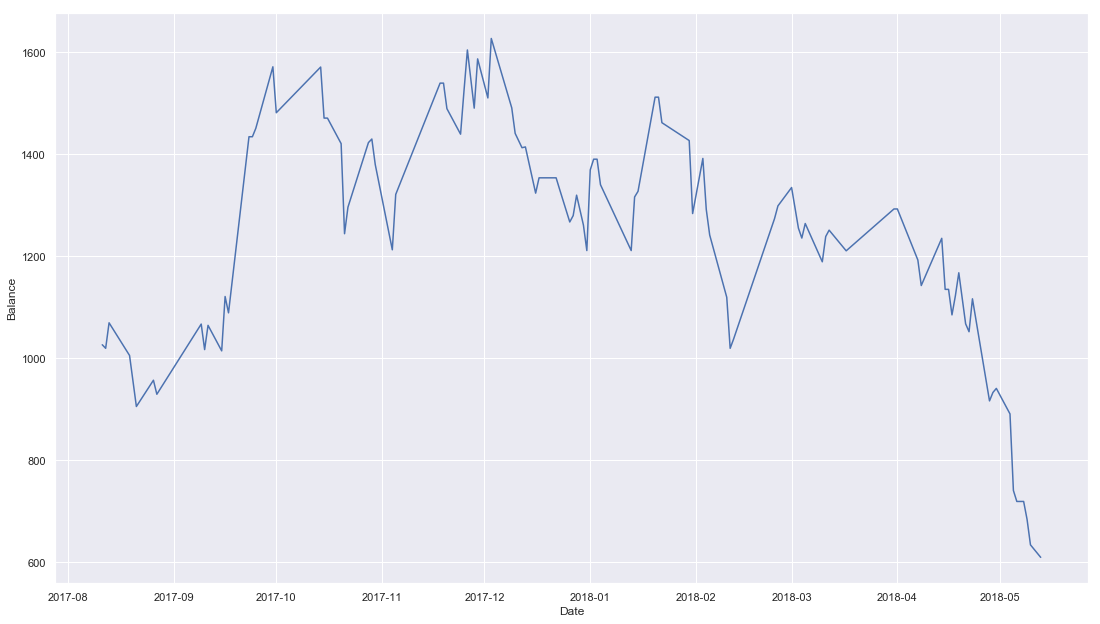

In [67]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim['Balance']))
g = sns.lineplot(data=df_sim, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)

In [74]:
fixtures_2016 = pd.DataFrame(df[df['Year'] == validate_year])
fixtures_2016['Date'] = pd.to_datetime(fixtures_2016['Date'], dayfirst=True)
fixtures_2016.sort_values(['Date'], inplace=True)
# fixtures_2016.dropna(subset=['Year'], inplace=True)
fixtures_2016
df_sim_2016 = naive_method(fixtures_2016)
df_sim_2016

Starting balance: 1000
2016-08-13 00:00:00 Pay: -50 on West Brom in [ Crystal Palace vs West Brom ] Pred: Win Actual: Win
2016-08-13 00:00:00 Receive: 225.0 Odd: 4.5 Balance: 1175.0
2016-08-13 00:00:00 Pay: -50 on Leicester in [ Hull vs Leicester ] Pred: Win Actual: Lose
2016-08-13 00:00:00 Pay: -50 on Man City in [ Man City vs Sunderland ] Pred: Win Actual: Win
2016-08-13 00:00:00 Receive: 62.5 Odd: 1.25 Balance: 1087.5
2016-08-13 00:00:00 Pay: -50 on Stoke in [ Middlesbrough vs Stoke ] Pred: Lose Actual: Draw
2016-08-14 00:00:00 Pay: -50 on Man United in [ Bournemouth vs Man United ] Pred: Win Actual: Win
2016-08-14 00:00:00 Receive: 92.5 Odd: 1.85 Balance: 1030.0
2016-08-15 00:00:00 Pay: -50 on Chelsea in [ Chelsea vs West Ham ] Pred: Win Actual: Win
2016-08-15 00:00:00 Receive: 82.5 Odd: 1.65 Balance: 1062.5
2016-08-19 00:00:00 Pay: -50 on Man United in [ Man United vs Southampton ] Pred: Win Actual: Win
2016-08-19 00:00:00 Receive: 76.5 Odd: 1.53 Balance: 1089.0
2016-08-20 00:00:0

2016-11-06 00:00:00 Pay: -50 on Liverpool in [ Liverpool vs Watford ] Pred: Win Actual: Win
2016-11-06 00:00:00 Receive: 64.5 Odd: 1.29 Balance: 1963.5
2016-11-06 00:00:00 Pay: -50 on Southampton in [ Hull vs Southampton ] Pred: Win Actual: Lose
2016-11-19 00:00:00 Pay: -50 on Tottenham in [ Tottenham vs West Ham ] Pred: Win Actual: Win
2016-11-19 00:00:00 Receive: 75.0 Odd: 1.5 Balance: 1838.5
2016-11-19 00:00:00 Pay: -50 on Man City in [ Crystal Palace vs Man City ] Pred: Win Actual: Win
2016-11-19 00:00:00 Receive: 76.5 Odd: 1.53 Balance: 1865.0
2016-11-19 00:00:00 No bet in Sunderland vs Hull
2016-11-20 00:00:00 Pay: -50 on Chelsea in [ Middlesbrough vs Chelsea ] Pred: Win Actual: Win
2016-11-20 00:00:00 Receive: 78.5 Odd: 1.57 Balance: 1743.5
2016-11-21 00:00:00 Pay: -50 on West Brom in [ West Brom vs Burnley ] Pred: Win Actual: Win
2016-11-21 00:00:00 Receive: 97.5 Odd: 1.95 Balance: 1791.0
2016-11-26 00:00:00 Pay: -50 on Chelsea in [ Chelsea vs Tottenham ] Pred: Win Actual: Win


2017-03-12 00:00:00 Pay: -50 on Liverpool in [ Liverpool vs Burnley ] Pred: Win Actual: Win
2017-03-12 00:00:00 Receive: 62.5 Odd: 1.25 Balance: 1626.0
2017-03-18 00:00:00 Pay: -50 on Burnley in [ Sunderland vs Burnley ] Pred: Lose Actual: Draw
2017-03-18 00:00:00 Pay: -50 on Chelsea in [ Stoke vs Chelsea ] Pred: Win Actual: Win
2017-03-18 00:00:00 Receive: 81.0 Odd: 1.62 Balance: 1557.0
2017-03-18 00:00:00 Pay: -50 on Leicester in [ West Ham vs Leicester ] Pred: Win Actual: Win
2017-03-18 00:00:00 Receive: 165.0 Odd: 3.3 Balance: 1672.0
2017-03-18 00:00:00 Pay: -50 on Crystal Palace in [ Crystal Palace vs Watford ] Pred: Win Actual: Win
2017-03-18 00:00:00 Receive: 95.5 Odd: 1.91 Balance: 1717.5
2017-03-18 00:00:00 Pay: -50 on Bournemouth in [ Bournemouth vs Swansea ] Pred: Win Actual: Win
2017-03-18 00:00:00 Receive: 107.5 Odd: 2.15 Balance: 1775.0
2017-03-18 00:00:00 Pay: -50 on Everton in [ Everton vs Hull ] Pred: Win Actual: Win
2017-03-18 00:00:00 Receive: 76.5 Odd: 1.53 Balance:

,Date,Balance
0,2016-08-13,987.5
1,2016-08-14,1030.0
2,2016-08-15,1062.5
3,2016-08-19,1089.0
4,2016-08-20,1048.0
5,2016-08-21,1095.5
6,2016-08-27,1066.5
7,2016-08-28,1029.0
8,2016-09-10,995.0
9,2016-09-11,995.0


2419.0


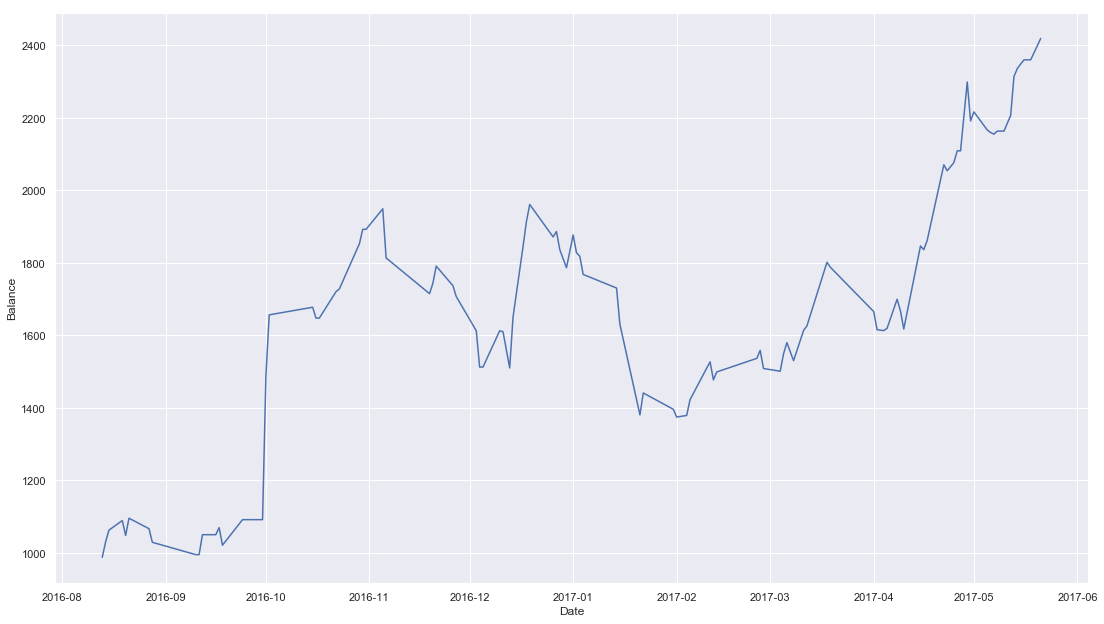

In [69]:
%matplotlib inline
import seaborn as sns
sns.set()
print(max(df_sim_2016['Balance']))
g = sns.lineplot(data=df_sim_2016, x='Date', y='Balance')
g.figure.set_size_inches(18.5, 10.5)